# Банки — Анализ оттока клиентов

## Основные задачи исследования

Настоящее исследование проводится по заказу банка  «Метанпром». Основная цель проекта — выявить категории клиентов, которые чаще всего перестают пользоваться услугами банка.  

Изучив основные характеристики клиентов нам нужно сформировать как портрет типичного клиента банка, так  и  портреты клиентов, наиболее часто покидающих банк.

В результате исследования нам нужно выявить основные признаки, которые будут в дальнейшем сигнализировать о повышенных рисках оттока клиента.

Изучив все возможные причины ухода клиентов, мы сможем сформировать стратегию удержания каждой из категорий клиентов.

## Порядок выполнения работ

1. Загрузка библиотек
2. Обзор данных
3. Предобработка данных
   * Замена названий колонок
   * Анализ пропусков
   * Кодирование значений переменной пола
   * Изучение дубликатов
   * Кодирование переменной города
   * Изучение выбросов
   * Удаление аномалий
4. Исследовательский анализ
   * Средний показатель оттока по банку
   * Портреттипичного клиента банка
   * Тепловая карта корреляций
   * Изучим распределения переменных
5. Статистический анализ
6. Сегментация
7. Выводыи рекоммендации банку   


## 1.Загрузка библиотек

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
pd.options.display.float_format = '{: .2f}'.format
import statsmodels.api as sm

## 2. Обзор данных

In [ ]:
banks = pd.read_csv('https://code.s3.yandex.net/datasets/bank_scrooge.csv')
banks.head()

,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
0,183012,850.00,Рыбинск,Ж,25.00,1,59214.82,2,0,1,75719.14,1
1,146556,861.00,Рыбинск,Ж,37.00,5,850594.33,3,1,0,86621.77,0
2,120722,892.00,Рыбинск,Ж,30.00,0,NaN,1,1,1,107683.34,0
3,225363,866.00,Ярославль,Ж,51.00,5,1524746.26,2,0,1,174423.53,1
4,157978,730.00,Ярославль,М,34.00,5,174.00,1,1,0,67353.16,1


In [ ]:
def lookup(df:pd.DataFrame) -> None:
    '''Функция для получения базовой информации о датафрейме'''
    print('Dataset shape',df.shape,"example:")
    display(df.dropna().sample())
    display(df.info())
    for col in df.columns:
        n = df[col].nunique()
        if n < 15:
            display(df[col].value_counts(dropna=False).to_frame().T)
        elif np.issubdtype(df[col].dtype, np.number):
            print(f"{col} — {n} values. Min {df[col].min()}, max: {df[col].max()}, пропусков в колонке - {df[col].isna().sum()}")
        else:
            print(f"{col} — {n} values. Min {df[col].dropna().min()}, max: {df[col].dropna().max()}, пропсуков в колонке - {df[col].isna().sum()}")

In [ ]:
lookup(banks)

Dataset shape (10000, 12) example:


,USERID,score,city,gender,age,equity,balance,products,credit_card,last_activity,EST_SALARY,churn
3136,153530,925.00,Ярославль,Ж,59.00,4,525584.39,2,0,0,102322.71,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   USERID         10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  EST_SALARY     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


None

USERID — 9927 values. Min 94561, max: 229145, пропусков в колонке - 0
score — 348 values. Min 642.0, max: 1000.0, пропусков в колонке - 0


,Ярославль,Рыбинск,Ростов
city,5888,2695,1417


,М,Ж
gender,5005,4995


age — 68 values. Min 18.0, max: 86.0, пропусков в колонке - 26


,0,5,4,3,2,1,6,7,8,9
equity,2592,1918,1850,1543,1052,774,161,80,17,13


balance — 7701 values. Min 0.0, max: 119113552.01, пропусков в колонке - 2295


,2,1,3,4,5,0
products,5126,3341,1039,474,19,1


,1,0
credit_card,6804,3196


,1,0
last_activity,5235,4765


EST_SALARY — 9996 values. Min 2546.3, max: 1395064.45, пропусков в колонке - 0


,0,1
churn,8180,1820


### Выводы и наблюдения:

Данные представленные в датасете, содержат 10000 строк, из которых только в двух колонках присутсвуют пропуски ('age', 'balance').
Датасет содердит важные сведения о клиентах банка. Кратко опишем основные признаки:

* Клиенты обслуживаются в 3 городах: Ярославле, Рыбинске и Ростове. Большинство клиентов из Ярославля
*   Мужчин  немного больше чем женщин
*   Минимальный возраст - 18 лет, максимальный - 86 лет
*   Каждому клиенту присвоены баллы кредитного скоринга. Диапазон значений от 642 до 1000
*   Колонка equity описывает собственность клиентов (значения от 0 до 9), где 0 - отсутствие собственности а 9 - максимальное количество объектов собственности
*   Колонка products хранит информацию о числе банковских продуктов, которыми пользуются клиенты. Минимальное значение - 0, максимальное - 5
*   Колонка credit cards сообщает, есть ли у клиента кредитная карта
*   Колонка last activity сообщает, были ли у клиентов какие-то взаимодействия с продуктами банка в последнее время
*   Колонка  Churn наиболее важна для нашего исследования, так как именно в ней мы получаем информации о свершившемся или ожидаемом уходе клиента из банка. Значения переменной - 1 (клиент ушел) и 0 (клиент остался)


## 3.Предобработка данных

### 3.1 Заменим названия колонок

In [ ]:
banks = banks.rename(columns = {'USERID':'user_id', 'EST_SALARY': 'est_salary'})
banks.sample()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn
8793,207144,815.00,Ярославль,Ж,62.00,2,455969.27,3,0,0,119280.34,0


###  3.2 Анализ пропусков


Мы ранее наблюдали пропуски в двух колонках. В столбце age пропусков всего 26. Это очень небольшой процент  и их можно удалить. В столбце balance их много. Изучим возможные причины этих пропусков.

In [ ]:
print(f"Доля пропусков в столбце age составляет {banks['age'].isna().sum()/len(banks):.2%}")

Доля пропусков в столбце age составляет 0.26%


In [ ]:
banks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   user_id        10000 non-null  int64  
 1   score          10000 non-null  float64
 2   city           10000 non-null  object 
 3   gender         10000 non-null  object 
 4   age            9974 non-null   float64
 5   equity         10000 non-null  int64  
 6   balance        7705 non-null   float64
 7   products       10000 non-null  int64  
 8   credit_card    10000 non-null  int64  
 9   last_activity  10000 non-null  int64  
 10  est_salary     10000 non-null  float64
 11  churn          10000 non-null  int64  
dtypes: float64(4), int64(6), object(2)
memory usage: 937.6+ KB


In [ ]:
banks = banks.dropna(subset = ['age'])

In [ ]:
print(f"Доля пропусков в столбце balance составляет {banks['balance'].isna().sum()/len(banks):.2%}")

Доля пропусков в столбце balance составляет 22.85%


Это доля пропусков слишком велика, и нам нужно сохранить эту часть датафрейма. Посмотрим, какими могут быть возможные причины пропусков в этой колонке.

Создадим срез датафрейма, в котором будут все пропущенные значения колонки balance

In [ ]:
def nan_marker(num):
  if num!=num:
    return 1
  else:
    return 0

In [ ]:
banks_balance = banks.copy(deep = True)
banks_balance['balance_nan'] = banks_balance['balance'].apply(nan_marker)

In [ ]:
banks_balance_group = (
    banks_balance.groupby('balance_nan')
    .agg({'score':'mean', 'age':'median', 'gender':lambda x: x.value_counts().idxmax(), 'city':lambda x: x.value_counts().idxmax(),
                   'equity':'median',  'products': 'median',
                   'credit_card':'median', 'last_activity':'median', 'est_salary':'median', 'churn':'mean'}))
banks_balance_group

,score,age,gender,city,equity,products,credit_card,last_activity,est_salary,churn
balance_nan,,,,,,,,,,
0,843.74,40.00,Ж,Ярославль,4.00,2.00,1.00,1.00,106250.18,0.23
1,865.36,40.00,М,Ярославль,0.00,1.00,1.00,1.00,174347.87,0.01


**Комментарий**
Мы наблюдаем достаточно большую долю пропусков в колонке balance. При этом мы видим, что показатели оттока именно для этих клиентов очень низкие.

Мы также наблюдаем, что у этих клиентов меньшее количество продуктов банка и меньшее число объектов собственности. Уровень зарплаты выше, чем у клиентов банка, где не было пропусков


Возможная гипотеза - это клиенты, которые еще не завершили процесс открытия банковского счета, поэтому банк еще не заполнил данные о балансе, однако, в большинстве случаев банк не ожидает оттока этих клиентов.

Мы предполагаем, что пропуски относятся к категории MNAR, и их наличие связано с данными.

Для нас важно сохранить пропуски как есть. При исследовании влияние фактора balance на показатели оттока будем воспринимать категорию nan как отдельную категорию

###  3.3 Заменим значения пола на 0 и 1

In [ ]:
banks['gender_num'] = pd.factorize(banks['gender'])[0]
banks.sample()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_num
2073,216705,808.00,Ярославль,Ж,55.00,2,775333.24,2,0,1,162029.44,1,0


### 3.4 Изучим дубликаты

In [ ]:
banks.duplicated().sum()

0

В датафрейме отсутствуют явные дубликаты

In [ ]:
banks['user_id'].duplicated().sum()

50

Мы видим дубли в колонке user_id. Рассмотрим срез датафрейма, в котором находятся все строки с дублями user_id

In [ ]:
duplicated_id = list(banks[banks['user_id'].duplicated()]['user_id'])
banks_dubles = banks.query('user_id in @duplicated_id').sort_values(by = 'user_id').reset_index().drop(columns = 'index')
banks_dubles.head(10)

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_num
0,116540,883.00,Рыбинск,Ж,55.00,1,362756.49,3,0,1,175920.48,1,0
1,116540,887.00,Ярославль,Ж,38.00,0,NaN,1,0,1,119247.61,0,0
2,117943,855.00,Рыбинск,Ж,32.00,6,1036832.93,4,1,1,107792.71,1,0
3,117943,880.00,Ярославль,Ж,40.00,0,NaN,1,1,0,137718.93,0,0
4,120258,908.00,Рыбинск,Ж,38.00,4,2213581.63,2,0,1,160327.77,1,0
5,120258,905.00,Ярославль,М,30.00,0,NaN,1,1,1,146427.96,0,1
6,123461,829.00,Ярославль,Ж,59.00,0,96222.44,2,0,1,102771.55,1,0
7,123461,934.00,Рыбинск,М,34.00,0,NaN,2,1,0,291619.27,0,1
8,124450,758.00,Рыбинск,Ж,36.00,0,73574.07,2,0,1,79963.59,0,0
9,124450,859.00,Ярославль,Ж,38.00,6,516811.20,1,1,1,95144.63,1,0


In [ ]:
banks_dubles['city'].value_counts()

Рыбинск      50
Ярославль    50
Name: city, dtype: int64

Все дублирующие id- это люди из Ярославля и Рыбинска поровну

In [ ]:
banks_gr = banks_dubles.groupby('user_id').agg({'churn':'sum'}).reset_index()
banks_gr.head(3)

,user_id,churn
0,116540,1
1,117943,1
2,120258,1


In [ ]:
banks_gr['churn'].value_counts()

1    50
Name: churn, dtype: int64

**Наши предположения:**
Прежде всего стоит поговорить с менеджером банка о возможных причинах подобной ошибки в данных. Возможно, такая ошибка возникала в тех случаях, когда клиент покидал банк, а его освободившийся номер по ошибке приваивался новому клиенту.  Другая возможная причина, так как у нас указан разный город, то скорее всего это связано с тем, что в городах в одно время заводили карточки или система сбоила. На данном этапе мы принимаем решение не удалять данные, так как по другим значениям столбцов мы видим разных людей по полу, возрасту, балансу. В дальнейшем нам следует сообщить об ошибке в данных сотрудникм банка


### 3.5 Закодируем категориальные переменные

Сделаем копию датафрейма и уже в нем будем кодировать переменные gender и city

In [ ]:
bank = banks.copy(deep = True)

In [ ]:
bank['gender_num'] = pd.factorize(bank['gender'])[0]
bank.sample()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_num
7067,159743,762.00,Ярославль,М,34.00,4,187329.94,2,1,1,93620.35,0,1


In [ ]:
bank = bank.rename(columns = {'user_id':'id',  'gender':'пол','score':'рейтинг', 'age':'возраст', 'equity': 'собственность', 'balance':'баланс','products':'продукты', 'credit_card':'кредитная_карта', 'last_activity':'последняя_активность', 'est_salary':'зарплата', 'churn':'показатель_оттока','gender_num':'пол_группа', 'city':'город'})

In [ ]:
bank_num = pd.get_dummies(bank, columns = ['город'])

В новом датафрейме заменим названия на руускоязычные для удобства отображения на графиках

In [ ]:
bank_num.sample()

,id,рейтинг,пол,возраст,собственность,баланс,продукты,кредитная_карта,последняя_активность,зарплата,показатель_оттока,пол_группа,город_Ростов,город_Рыбинск,город_Ярославль
5486,119524,882.00,М,27.00,3,573808.13,2,0,1,43644.45,1,1,1,0,0


Теперь мужскому роду соотвествует 1, женскому - 0. Мы также добавили колонки с признаками принадлежности к каждому городу.

### 3.6 Изучим выбросы

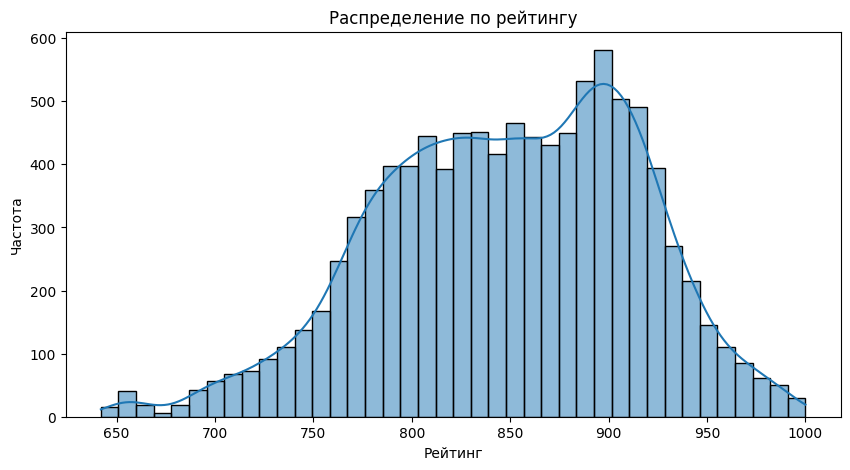

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(bank, x = 'рейтинг', kde = True)
plt.xlabel('Рейтинг')
plt.ylabel('Частота')
plt.title('Распределение по рейтингу')
plt.show()

Чаще всего рейтинг колеблется от 802 до 900. Выбросов нет

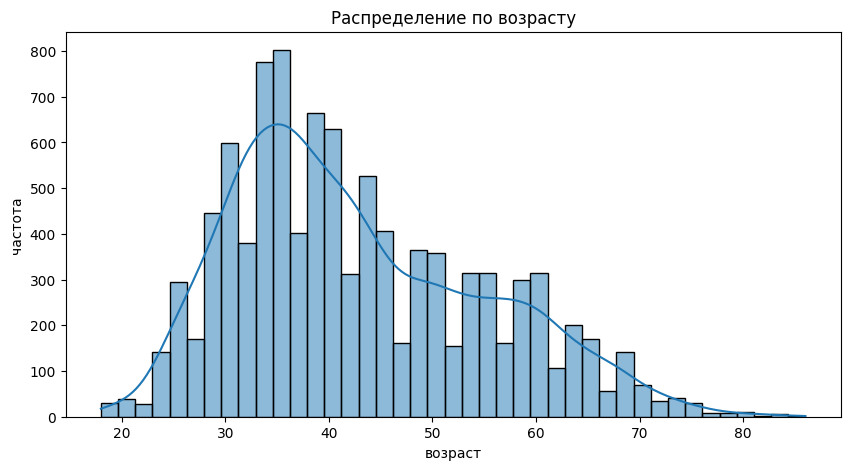

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(bank, x = 'возраст', kde = True)
plt.xlabel('возраст')
plt.ylabel('частота')
plt.title('Распределение по возрасту')
plt.show()

Самый частотный возраст клиента от 33 до 51 лет

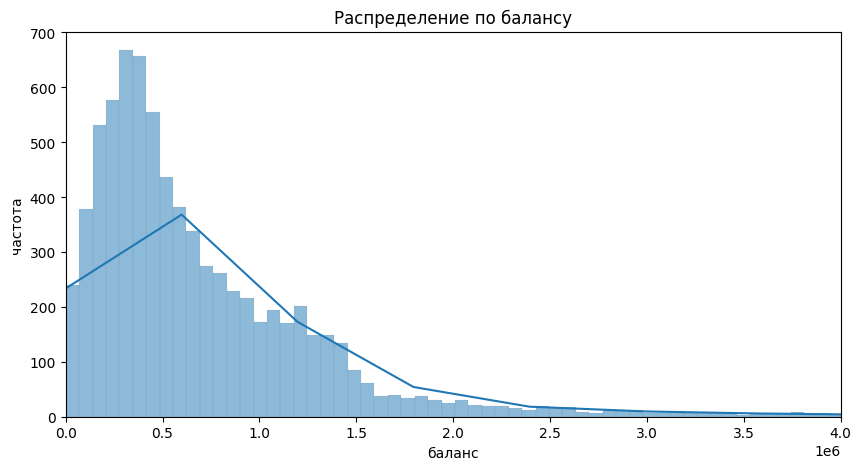

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(bank, x = 'баланс', kde = True)
plt.xlim(-2, 4000000)
plt.xlabel('баланс')
plt.ylabel('частота')
plt.title('Распределение по балансу')
plt.show()

In [ ]:
bank['баланс'].describe()

count         7695.00
mean        827245.59
std        1980327.41
min              0.00
25%         295698.71
50%         524295.33
75%         980051.21
max      119113552.01
Name: баланс, dtype: float64

Чаще всего клиенты держат на бадлансе от 295 до 980 тыс. Однако, в данных присутствуют и выбросы, так как максимальное значение - 119 млн. Удалять выбросы не будем, так как такие разбросы вполне вероятны

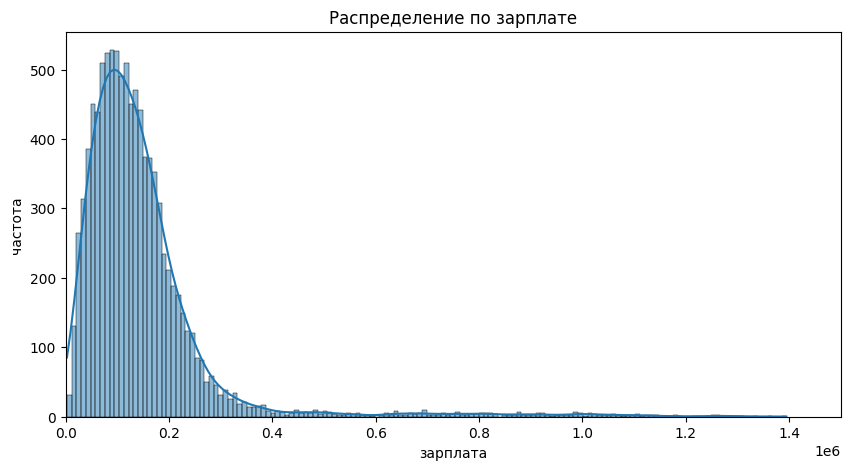

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(bank, x = 'зарплата', kde = True)
plt.xlim(-2, 1500000)
plt.xlabel('зарплата')
plt.ylabel('частота')
plt.title('Распределение по зарплате')
plt.show()

In [ ]:
bank['зарплата'].describe()

count       9974.00
mean      147786.81
std       139285.51
min         2546.30
25%        75251.66
50%       119626.79
75%       174499.81
max      1395064.45
Name: зарплата, dtype: float64

Чаще всего зарплата колеблется от 75 до 174 тыс. Но в данных есть и выбросы. Максимальные значения достигают 1.4 млн. Такие выбросы также вполне вероятны и данные мы удалять не будем

### 3.7 Удаление аномалий

Мы ранее указывали причины, по которым нецелесообразно удалить строки с выбросами по зарплатам и балансу. Однако, нам представляется необходимым удалить одну строку, в которой значение продукта указан 0. (Она единственная в нашем датафрейме и ее наличие может исказить дальнейший исследовательски анализ данных

In [ ]:
bank.sample()

,id,рейтинг,город,пол,возраст,собственность,баланс,продукты,кредитная_карта,последняя_активность,зарплата,показатель_оттока,пол_группа
7744,177438,889.00,Рыбинск,Ж,54.00,5,1120389.07,2,1,1,144310.18,0,0


In [ ]:
bank_num = bank_num.query('продукты !=0')

### Результаты предобработки данных:


*   Мы заменили названия колонок, а также сделали  копию датафрейма (bank) с русскоязычными названиями всех колонок.

*   Мы удалили пропуски в колонке'age', а также исследовали причину пропусков в колонке 'balance'. возможная причина пропусков - незавершенная регистрация клиентов в банке, так как показатели оттока у этой группы клиентов очень низкие. На данном этапе оставим пропуски без изменения

*   Мы закодировали категориальные переменные (пол и город) для более удобного анализа корреляций. Все данные с закодированными значениями переменных мы сохранили в новый датафрейм bank_num

*   Мы изучили дубли в датафрейме и обнаружили 100 строк, в которых user_id повторялись по 2 раза. Мы видим, что один их двух повторяющихся дублей всегда из Ярославля, а второй всегда из Рыбинска.У одного показатель оттока всегда равен 1, а у другого - 0.  Возможно, такая ошибка возникала в тех случаях, когда клиент покидал банк, а его освободившийся номер по ошибке приваивался новому клиенту. На данном этапе мы принимаем решение не удалять данные, так как по другим значениям столбцов мы видим разных людей по полу, возрасту, балансу.

*  Мы изучили распределения количественных непрерывных переменных, в двух случаях (колонки баланс и зарплата) были зафиксированы выбросы. Выбросы сохраняем, так как такая картина естественна для подобных распределений.





## 4. Исследовательский анализ

### 4.1 Просчитаем средний показатель оттока по банку

In [ ]:
print(f"В банке показатель оттока составляет {banks['churn'].mean():.2%}")

В банке показатель оттока составляет 18.24%


In [ ]:
bank.sample()

,id,рейтинг,город,пол,возраст,собственность,баланс,продукты,кредитная_карта,последняя_активность,зарплата,показатель_оттока,пол_группа
2249,169240,839.00,Ярославль,М,25.00,5,250245.02,2,1,0,53690.49,1,1


In [ ]:
labl = ['клиенты ушли', 'клиенты остались', ]
val = [round(bank['показатель_оттока'].mean(),2), round((1- bank['показатель_оттока'].mean()),2)]

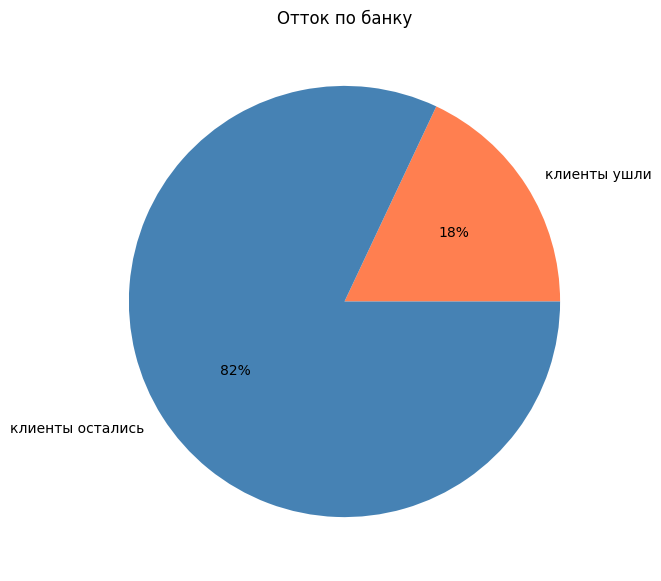

In [ ]:
plt.figure(figsize=(7, 7))
plt.pie(val, labels=labl, colors = ['coral', 'steelblue'], autopct='%.0f%%')
plt.title('Отток по банку')
plt.show()

### 4.2 Составим портрет типичного клиента банка

In [ ]:
bank_group = (
             bank.groupby('показатель_оттока')
             .agg({'рейтинг':'mean', 'возраст':'median', 'пол': lambda x: x.value_counts().idxmax(),
                    'город': lambda x: x.value_counts().idxmax(),
                   'собственность':'median', 'баланс':'mean', 'продукты': 'median',
                   'кредитная_карта':'median', 'последняя_активность':'median', 'зарплата':'mean'}).T
             .rename(columns = {0:'клиенты остались', 1: 'клиентв ушли'}))
bank_group

показатель_оттока,клиенты остались,клиентв ушли
рейтинг,845.40,863.42
возраст,40.00,39.00
пол,Ж,М
город,Ярославль,Ярославль
собственность,3.00,4.00
баланс,733031.63,1134458.21
продукты,2.00,2.00
кредитная_карта,1.00,1.00
последняя_активность,0.00,1.00
зарплата,147674.64,148289.70


In [ ]:
bank_group1 = bank_group.T[['рейтинг', 'баланс', 'зарплата', 'возраст', 'собственность']]

In [ ]:
result = (bank_group1.iloc[1] - bank_group1.iloc[0])/ bank_group1.iloc[0]*100
result_df = pd.DataFrame([result])
result_df

,рейтинг,баланс,зарплата,возраст,собственность
0,2.13,54.76,0.42,-2.50,33.33


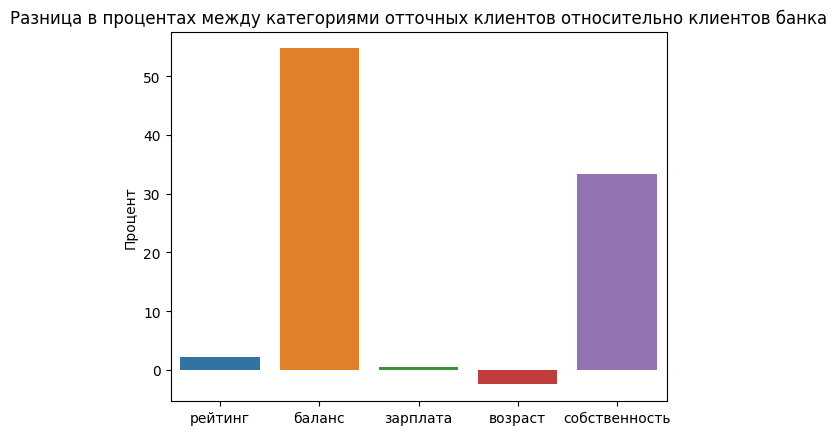

In [ ]:
sns.barplot(data = result_df).set(title = 'Разница в процентах между категориями отточных клиентов относительно клиентов банка')
plt.ylabel("Процент")
plt.show()

Итак, выделим основные признаки по которым клиенты, покинувшие или покидающие банк отличаются от типовых клентов банка


1.   Скоринговый рейтинг у отточных клиентов немного выше, чем у клиетов банка (на 2%)
2.   Баланс у отточных клиентов существенно выше (на 55%)
3.   Пол у отточных клиентов чаще мужской, у лояльных клиетов банка - чаще женский
4.   Объектов собственности у оточных клиетов немного больше, чем у иповых клиентов банка(чаще 4 объекта, у типовых клиенто - чаще 3)
5.   У отточных клиентов зафиксирована последняя активность (возможна - действия по закрытию счета), у типовых клиентов такой активности чаще не наблюдаем







### 4.3 Построим тепловую карту столбца корреляций

<ipython-input-50-379d125500c3>:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  bank_num.corr(method='spearman').loc[:,['показатель_оттока']].drop(['показатель_оттока','id'])


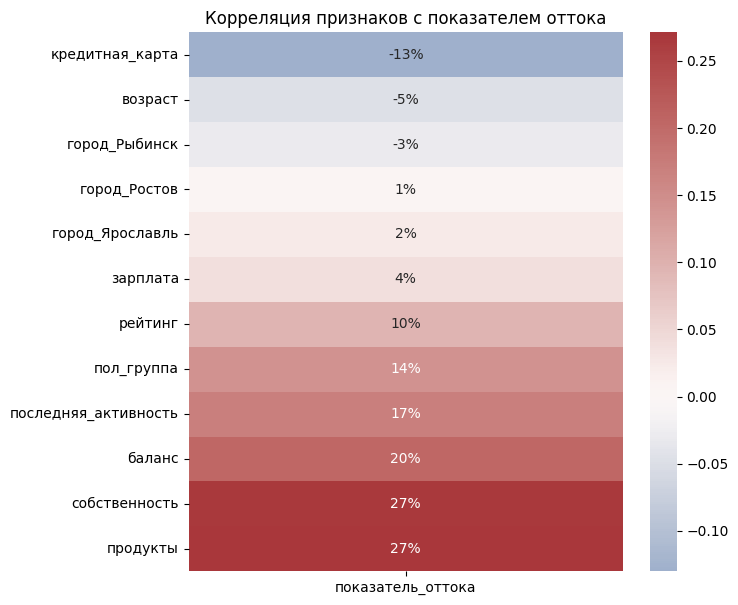

In [ ]:
plt.figure(figsize=(7, 7))
sns.heatmap(
    bank_num.corr(method='spearman').loc[:,['показатель_оттока']].drop(['показатель_оттока','id'])
    .sort_values('показатель_оттока'), annot = True, fmt = '.0%', cmap = 'vlag', center = 0).set(title='Корреляция признаков с показателем оттока')
plt.show()

Мы наблюдаем слабую положительную корреляцию с признаком оттока у следующих характеристик:

*   продукты банка (корреляция 27%)
*   объекты собственности (корреляция 27%)
*   баланс (корреляция 20%)
*   последняя активность (корреляция 17%)
*   половая группа (корреляция 14%)
*   рейтинг (корреляция 10%)
*   зарплата (корреляция 4%)

Мы также наблюдаем слабую отрицательную корреляцию с признаком оттока у следующих характеристик:
* возраст (корреляция - 5%)
*   кредитная карта (корреляция -13%)

### 4.4 Зафиксируем переменные banks_churn и banks_churn2,

Они соответсвуют  уровню оттока и двойному значению уровня оттока по банку

In [ ]:
banks_churn = round(banks['churn'].mean(),3)
banks_churn

0.182

In [ ]:
banks_churn2 = banks_churn*2
banks_churn2

0.364

### 4.5 Изучим распределения переменных

In [ ]:
banks.sample()

,user_id,score,city,gender,age,equity,balance,products,credit_card,last_activity,est_salary,churn,gender_num
9111,185374,933.00,Рыбинск,Ж,39.00,0,NaN,1,1,0,111667.44,0,0


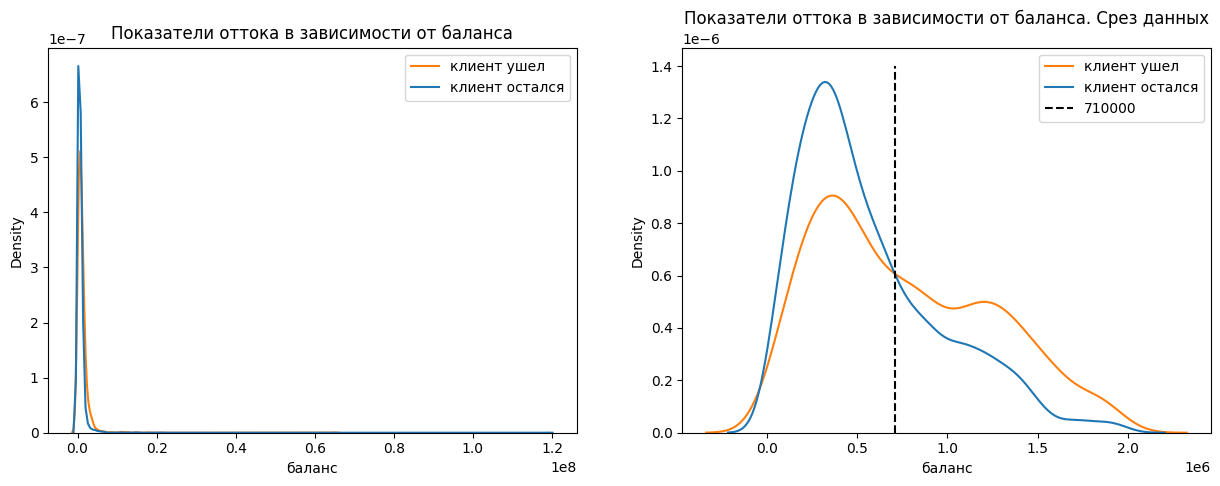

In [ ]:
plt.figure(figsize=(15, 5))
ax1= plt.subplot(1, 2, 1)
sns.kdeplot(
    data = bank, x = 'баланс', hue = 'показатель_оттока',
    common_norm = False, ax = ax1).set(title='Показатели оттока в зависимости от баланса')
plt.legend(labels=['клиент ушел', 'клиент остался'])
ax2 = plt.subplot(1, 2, 2)
sns.kdeplot(
    data = bank.query('баланс < 1990000'), x = 'баланс', hue = 'показатель_оттока',
    common_norm = False, ax = ax2).set(title='Показатели оттока в зависимости от баланса. Срез данных')
ax2.vlines([710000], 0, 0.0000014, color ="black",  linestyle='--', label='710000')
plt.legend(labels=['клиент ушел', 'клиент остался', '710000'])
plt.show()

Мы видим, что у клиентов с балансом больше 710000 случаи оттока более частотны, чем случаи лояльности банку

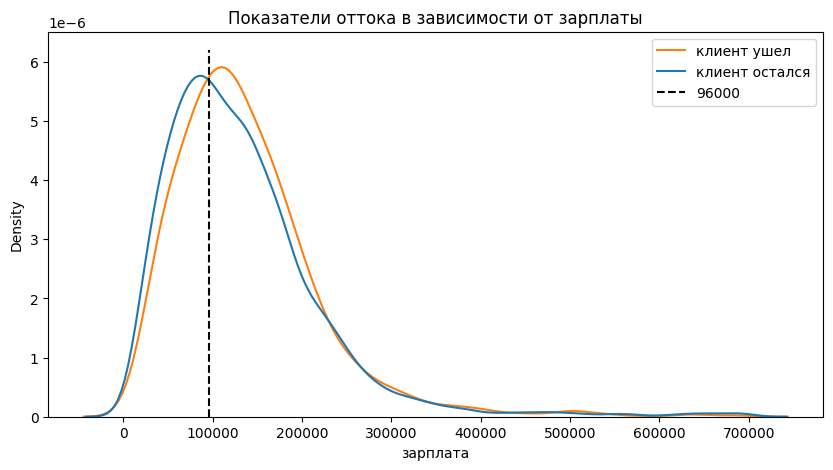

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(
    data = bank.query('зарплата < 700000'),
    x = 'зарплата',
    hue = 'показатель_оттока', common_norm = False).set(title='Показатели оттока в зависимости от зарплаты')
ax.vlines([96000], 0, 0.0000062, color ="black",  linestyle='--')
plt.legend(labels=['клиент ушел', 'клиент остался', '96000'])
plt.show()

Cущественного влияния зарплаты на отток мы не наблюдаем, однако мы видим, что клиенты с зарплатой более 96000 уходят из банка неного чаще.

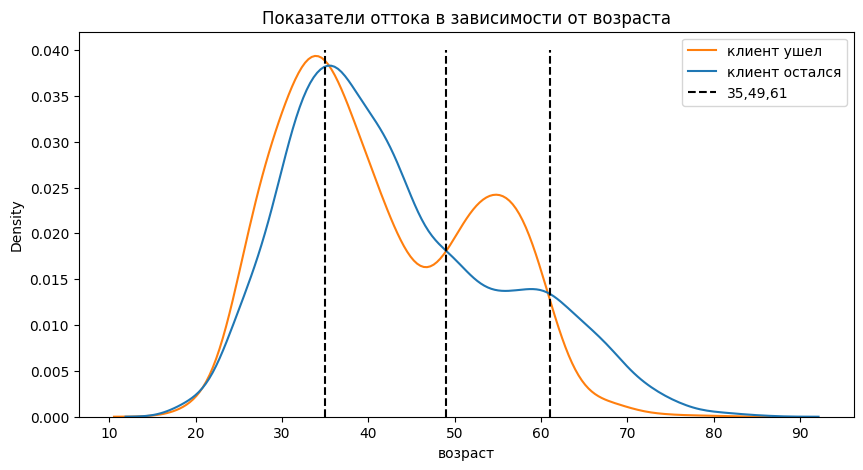

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(
    data = bank, x = 'возраст',
    hue = 'показатель_оттока',
    common_norm = False).set(title='Показатели оттока в зависимости от возраста')
ax.vlines([35, 49, 61], 0, 0.04, color ="black",  linestyle='--', label = 'Vertical Line')
plt.legend(labels=['клиент ушел', 'клиент остался', '35,49,61'])
plt.show()

Мы видим, что у клиентов в возрасте до 35, а  также в возрасте от 49 до 61 случаи оттока более частотны.

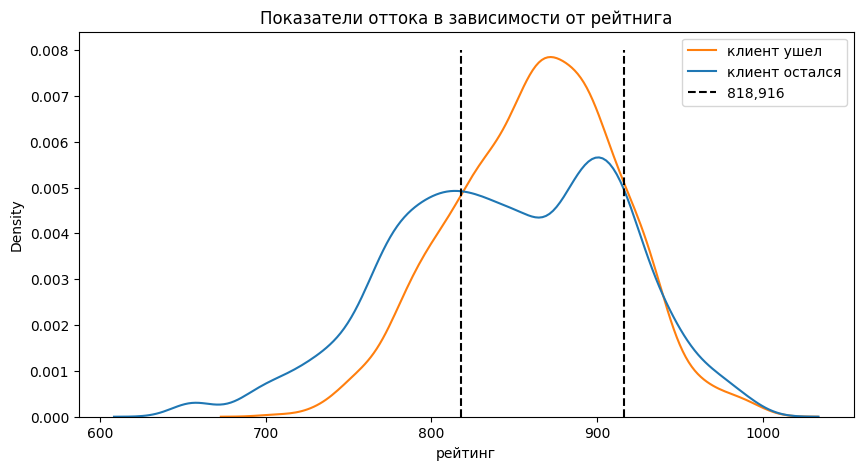

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.kdeplot(
    data = bank,
    x = 'рейтинг',
    hue = 'показатель_оттока',
    common_norm = False).set(title='Показатели оттока в зависимости от рейтнига')
ax.vlines([818, 916], 0, 0.008, color ="black",  linestyle='--')
plt.legend(labels=['клиент ушел', 'клиент остался', '818,916'])
plt.show()

мы видим, что клиенты с рейтингом в диапазоне от 818 до 916 чаще уходят из банка

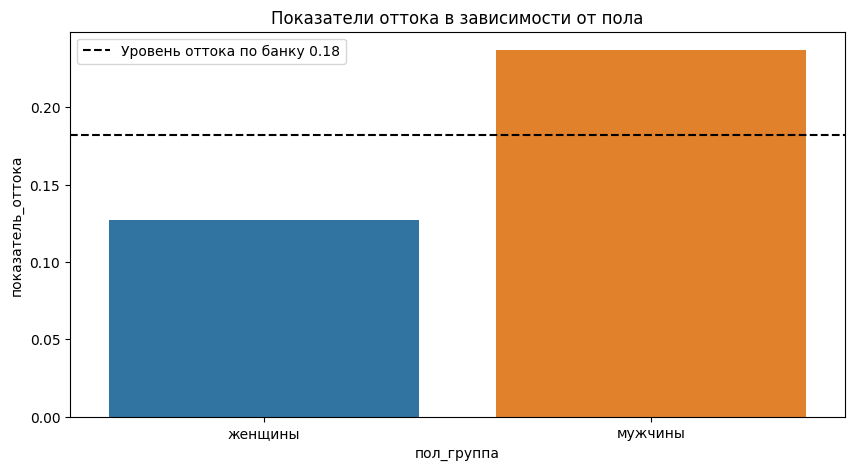

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(data = bank_num, x="пол_группа", y="показатель_оттока", errorbar=None).set(title='Показатели оттока в зависимости от пола')
plt.axhline(y=banks_churn, color='black', linestyle='--', label = 'Уровень оттока по банку 0.18')
labels=['женщины', 'мужчины']
plt.xticks([0,1], labels)
plt.legend()
plt.show()

Мужчины чаще покидают банк

In [ ]:
bank_num.groupby('продукты').agg({'показатель_оттока':'mean', 'продукты':'count'})

,показатель_оттока,продукты
продукты,,
1,0.07,3323
2,0.19,5119
3,0.29,1038
4,0.63,474
5,0.42,19


В наших данных только одна строка, где значению продукта равно 0. Удалим ее, так как она не представляетдля нас ценности.

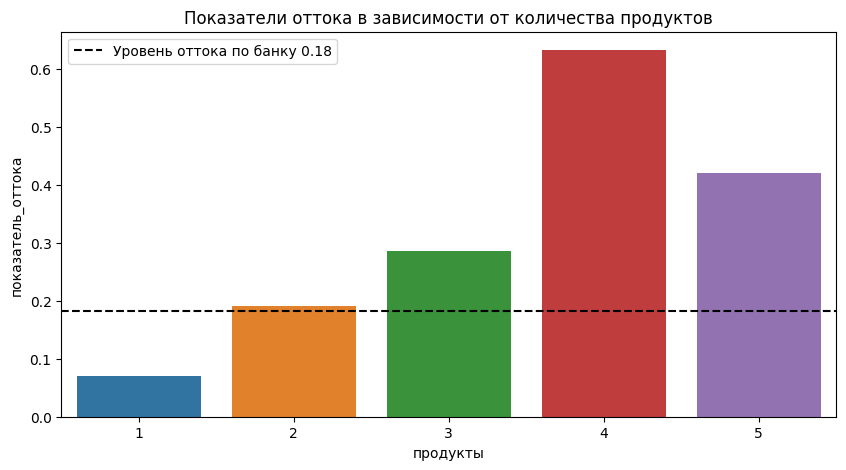

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = bank_num, x="продукты", y="показатель_оттока", errorbar=None).set(title='Показатели оттока в зависимости от количества продуктов')
plt.axhline(y=banks_churn, color='black', linestyle='--', label = 'Уровень оттока по банку 0.18')
plt.legend()
plt.show()

Мы видим, что клиенты, у которых 3,4, и 5 продуктов чаще уходят из банка

In [ ]:
bank_num.groupby('собственность').agg({'показатель_оттока':'mean', 'собственность':'count'})

,показатель_оттока,собственность
собственность,,
0,0.03,2576
1,0.12,773
2,0.16,1051
3,0.21,1540
4,0.25,1847
5,0.30,1915
6,0.36,161
7,0.46,80
8,0.35,17


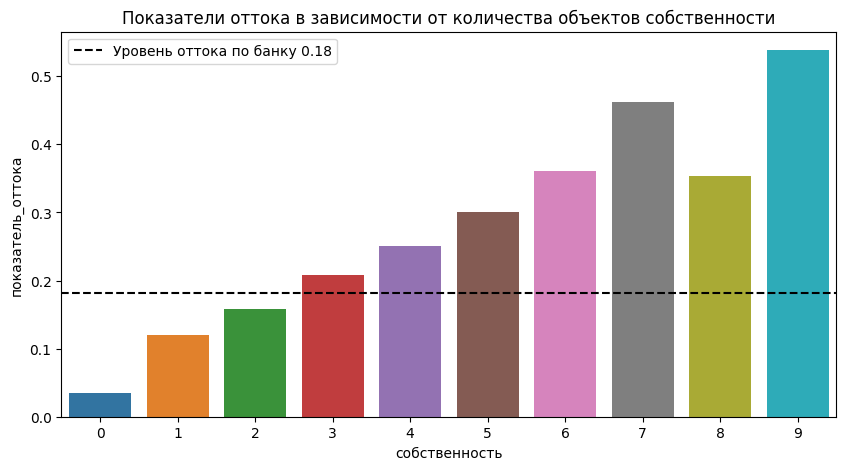

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = bank_num,
    x="собственность",
    y="показатель_оттока", errorbar=None).set(title='Показатели оттока в зависимости от количества объектов собственности')
plt.axhline(y=banks_churn, color='black', linestyle='--', label = 'Уровень оттока по банку 0.18')
plt.legend()
plt.show()

Мы видим, что клиенты с большим числом объектов собственности чаще уходят из банка.

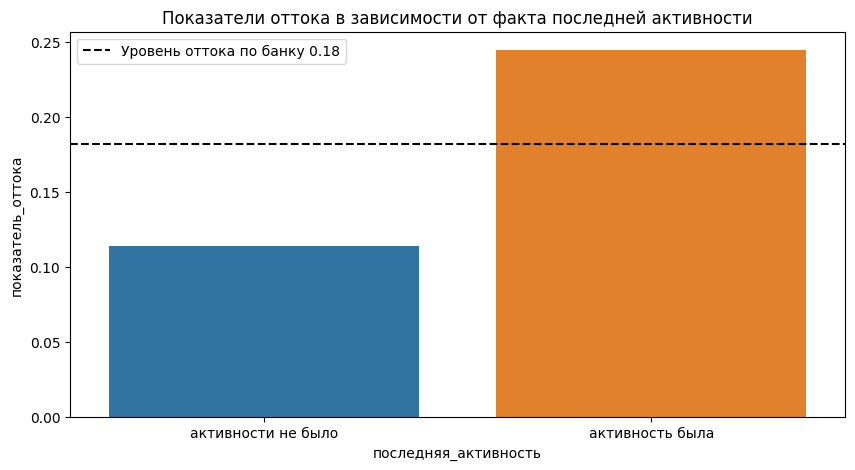

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data= bank_num,
    x="последняя_активность",
    y="показатель_оттока", errorbar=None).set(title='Показатели оттока в зависимости от факта последней активности')
plt.axhline(y=banks_churn, color='black', linestyle='--',label = 'Уровень оттока по банку 0.18')
labels=['активности не было', 'активность была']
plt.xticks([0,1], labels)
plt.legend()
plt.show()

У клиентов, покинувших банк, чаще наблюдалась последняя активность

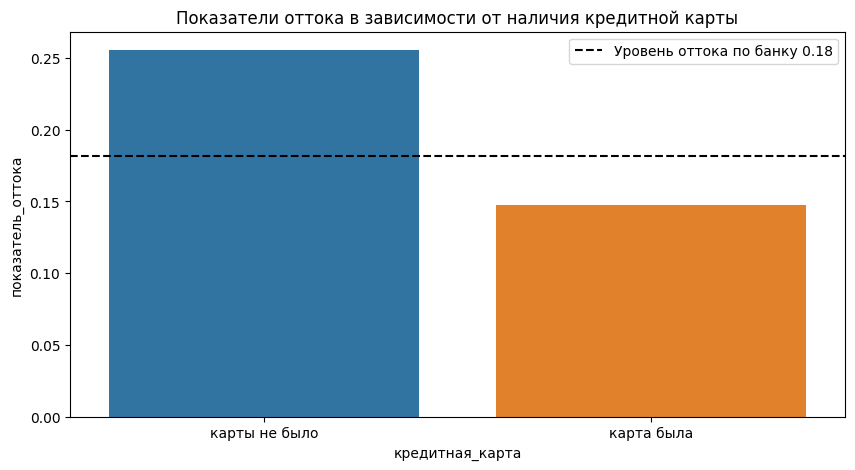

In [ ]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data = bank_num,
    x="кредитная_карта",
    y="показатель_оттока", errorbar=None).set(title='Показатели оттока в зависимости от наличия кредитной карты')
labels=['карты не было', 'карта была']
plt.xticks([0,1], labels)
plt.axhline(y=banks_churn, color='black', linestyle='--', label = 'Уровень оттока по банку 0.18')
plt.legend()
plt.show()

Клиенты, у которых нет кредитной карты, чаще покидают банк

### Предварительные выводы:

Итак, что большое всего с признаком оттока коррелируют следующие признаки:

*   продукты банка
*   объекты собственности
*   баланс
*   последняя активность
*   половая группа
*   рейтинг
*   наличия кредитная карты(обратная корреляция)




1.   Мы видим, что у клиентов с балансом больше 710000 случаи оттока более частотны, чем случаи лояльности банку
2.   У клиентов в возрасте до 35, а также в возрасте от 49 до 61 случаи оттока более частотны.
3.   Клиенты с рейтингом в диапазоне от 818 до 916 чаще уходят из банка
4.   Мужчины чаще покидают банк
5.   Клиенты, у которых 3,4, и 5 продуктов чаще уходят из банка
6.   Мы видим, что клиенты с большим числом объектов собственности(от 3) чаще уходят из банка.
7. У клиентов, покинувших банк, чаще наблюдалась последняя активность
8. Клиенты, у которых нет кредитной карты, чаще покидают банк


## Статистический анализ

В нашем исследовании мы будем использовать z-test, который чаще всего хорошо работает с анализом пропорций

In [ ]:
def ztest(df):
  """функция для проведения статистического теста"""
  list_one = bank['показатель_оттока']
  list_two = df['показатель_оттока']
  alpha = 0.05
  n1 = len(list_one)
  n2 = len(list_two)
  p1 = sum(list_one) / n1
  p2 = sum(list_two) / n2
  print(f"Доля оттока в выборке {p2}, больше доли оттока в банке на {(p2-p1)/p1:.2%}")
  z_score, p_value = sm.stats.proportions_ztest([sum(list_one), sum(list_two)], [n1, n2])
  print(f"p_value - {p_value}")
  if p_value/2 < alpha:
    print(f"Отвергаем нулевую гипотезу. Пропорции статистически различимы.")
  else:
    print(f"Нулевую гипотезу отвергнуть не удалось")

### Гипотеза 1

H0 Выборка клиентов, баланс которых больше 710000 не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов, баланс которых больше 710000, отличается от всей генеральной совокупности по признаку оттока, и доля оттока у них больше

In [ ]:
df = bank.query('баланс > 710000')

In [ ]:
ztest(df)

Доля оттока в выборке 0.3403361344537815, больше доли оттока в банке на 86.61%
p_value - 9.327675133177613e-73
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 2

H0 Выборка клиентов, возраст которых меньше 35 лет или находится в промежутке 49 до 61, не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов, возраст которых меньше 35 лет или находится в промежутке 49 до 61,  отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше


In [ ]:
ztest(bank.query('(возраст <35)|((возраст >=49)&(возраст <=61))'))

Доля оттока в выборке 0.22761790567545964, больше доли оттока в банке на 24.81%
p_value - 5.367974777458304e-11
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 3

H0 Выборка клиентов, рейтинг которых находится в диапазоне от  818  до 916 не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов, рейтинг которых находится в диапазоне от  818  до 916, отличается от всей генеральной совокупности по признаку оттока, и доля оттока у них больше

In [ ]:
ztest(bank.query('(рейтинг > = 818)&((рейтинг < = 916))'))

Доля оттока в выборке 0.23152236513726243, больше доли оттока в банке на 26.95%
p_value - 6.11570845417612e-13
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 4

H0 Выборка клиентов мужчин не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов мужчин  отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше

In [ ]:
ztest(bank.query('пол_группа == 1'))

Доля оттока в выборке 0.2370266479663394, больше доли оттока в банке на 29.97%
p_value - 3.5073074234302227e-15
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 5

H0 Выборка клиентов, у которых продуктов  3 или больше,  не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов,  у которых продуктов  3 или больше, отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше

In [ ]:
ztest(bank.query('продукты >=3'))

Доля оттока в выборке 0.395166557805356, больше доли оттока в банке на 116.68%
p_value - 1.4020078028701642e-80
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 6

H0 Выборка клиентов, у которых признак собственности от 3 и выше, не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов, у которых признак собственности от 3 и выше,  отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше

In [ ]:
ztest(bank.query('собственность >=3'))

Доля оттока в выборке 0.263724434876211, больше доли оттока в банке на 44.61%
p_value - 1.0349732098296029e-32
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 7

H0 Выборка клиентов, у которых была зафиксирована последняя активность,  не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов, у которых была зафиксирована последняя активность,  отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше

In [ ]:
ztest(bank.query('последняя_активность == 1'))

Доля оттока в выборке 0.2448705656759348, больше доли оттока в банке на 34.27%
p_value - 1.1008604427253338e-19
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 8

H0 Выборка клиентов, у которых нет кредитной карты,  не отличается от всей генеральной совокупности клиентов банка по признаку оттока

H1 Выборка клиентов, у которых нет кредитной карты,   отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше

In [ ]:
ztest(bank.query('кредитная_карта == 0'))

Доля оттока в выборке 0.25579937304075234, больше доли оттока в банке на 40.26%
p_value - 1.8530360446937354e-19
Отвергаем нулевую гипотезу. Пропорции статистически различимы.


### Гипотеза 9

Проверим гипотезу о том, что есть разница в доходах между клиентами который ушли, и клиентами, которые остались


Для проверки гипотезы будем использовать t-test и  u-критерий Манна-Уитни. Учитывая, что распеределения по зарплатам не относятся к нормальным, тест Манна-Уитни скорее всего даст более коректные результаты

In [ ]:
alpha = 0.05
list_one = bank.query('показатель_оттока == 0')['зарплата']
list_two = bank.query('показатель_оттока == 1')['зарплата']
results = st.ttest_ind(list_one, list_two, equal_var = False)
print('p-значение по t-test:', round(results.pvalue,3))
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между доходами клиентов, которые остались в банке и доходами клиентов, которые ушли.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Не наблюдаем статистическое различие между доходами клиентов, которые остались в банке и доходами клиентов, которые ушли.")

p-значение по t-test: 0.852
Не получилось отвергнуть нулевую гипотезу. Не наблюдаем статистическое различие между доходами клиентов, которые остались в банке и доходами клиентов, которые ушли.


In [ ]:
results1 = round(st.mannwhitneyu(list_one,list_two)[1],5)
print('p-значение, u-критерий Манна-Уитни:', results1)
if results1 < alpha:
    print("Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между доходами клиентов, которые остались в банке и доходами клиентов, которые ушли.")
else:
    print("Не получилось отвергнуть нулевую гипотезу. Не наблюдаем статистическое различие между доходами клиентов, которые остались в банке и доходами клиентов, которые ушли.")

p-значение, u-критерий Манна-Уитни: 0.00019
Отвергаем нулевую гипотезу. Наблюдаем статистическое различие между доходами клиентов, которые остались в банке и доходами клиентов, которые ушли.


В данном случае результаты критерия Манна-Уитни представляется нам более точным, так как наши распределения не нормальны. Мы можем говорить, влияние уровня дохода на отток статистически подтверждено

### Выводы


Итак, статистические тесты подтвердили все гипотезы, которые мы сформулировали на этапе статистического анализа



1.   Выборка клиентов, баланс которых больше 710000, отличается от всей генеральной совокупности по признаку оттока, и доля оттока у них больше
2.   Выборка клиентов, возраст которых меньше 35 лет или находится в промежутке 49 до 61, отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше
3. Выборка клиентов, рейтинг которых находится в диапазоне от 818 до 916, отличается от всей генеральной совокупности по признаку оттока, и доля оттока у них больше
4. Выборка клиентов мужчин отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше
5. Выборка клиентов, у которых продуктов 3 или больше, отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше
6. Выборка клиентов, у которых признак собственности от 3 и выше, отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше
7. Выборка клиентов, у которых была зафиксирована последняя активность, отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше
8. Выборка клиентов, у которых нет кредитной карты, отличается от всей генеральной совокупности клиентов банка по признаку оттока, и доля оттока у них больше
9. Наблюдаем статистическое различие между доходами клиентов, которые остались в банке и доходами клиентов, которые ушли.

## Сегментация

Выделим несколько сегментов наших с клиентов, для которых позднее банк сможет разработать стратегию удержания.

In [ ]:
def print_segm(df):
  """функция измеряет размер группы и процент оттока """
  print(f"Размер группы - {len(df)} человек")
  print(f"Показатель оттока - {df['показатель_оттока'].mean():.2%}")

### Группа 1. Клиенты, которые пользуются 4 продуктами банка и более

In [ ]:
print_segm(bank.query('продукты >=4'))

Размер группы - 493 человек
Показатель оттока - 62.47%


### Группа 2. Клиенты, на балансе у которых более полутора миллионов рублей


In [ ]:
print_segm(bank.query('(баланс > 1500000)'))

Размер группы - 719 человек
Показатель оттока - 50.07%


### Группа 3. Мужчины с  зарплатой более 150000 у которых оценка собственности 5 и более

In [ ]:
print_segm(bank.query('(зарплата >=150000)&(пол_группа== 1)&(собственность >=5)'))

Размер группы - 413 человек
Показатель оттока - 49.64%


### Группа 4. Клиенты, на балансе у которых более 700 тыс рублей и была замечена последняя активность¶

In [ ]:
print_segm(bank.query('(возраст >=49)&(возраст <=61)&(пол_группа== 1)&(кредитная_карта == 0)'))

Размер группы - 321 человек
Показатель оттока - 41.43%


## Выводы и рекомендации банку

Обобщив результаты исследования, мы можем констатировать повышенный отток у клиентов, которые активно пользуются продуктами банка, и на балансе которых достаточно много средств. Вероятно, у наиболее важных клиентов банка возникает повышенная неудовлетворенность сервисом и/или условиями обслуживания.

Таким образом, прежде всего мы бы порекомендовали провести исследования, помогающие выявить причины неудовлетворенности топовых клиентов.

Ниже мы рассмотрим рекомендациидля каждой группы клиентов, чаще всего покидающих банк


### Рекомендации по работе для каждого из сегментов

**Группа 1. Клиенты, которые пользуются 4 продуктами банка и более**

* Размер группы - 493 человек
* Показатель оттока - 62.47%

**Меры по удержанию:**

1. Выявить причины неудовлетворенности продуктами банка
2. Проанализировать предложения конкурентов
3. Назначить таким клиентам персональных менеджеров.
4. Ввести программу лояльности с бонусами, скидками и привилегиями для активных клиентов.

**Группа 2. Клиенты, на балансе у которых более полутора миллионов рублей**

* Размер группы - 719 человек
* Показатель оттока - 50%

**Меры по удержанию:**

1. Изучить предложения конкурентов по вкладам.
2. Предложить таким клиентам улучшенные условия по вкладам, такие как повышенные процентные ставки или дополнительные бонусы.
3. Предоставить специальные банковские карты с дополнительными преимуществами, такими как высокий кэшбэк или VIP-сервис
4. Предоставить доступ к уникальным инвестиционным продуктам или стратегиям, которые предоставляют высокий потенциал доходности.

**Группа 3. Мужчины с  зарплатой более 150000 у которых оценка собственности 5 и более**

* Размер группы - 413 человек
* Показатель оттока - 49.64%

**Меры по удержанию:**

1. Предложить доступ к эксклюзивным инвестиционным продуктам и стратегиям.
2. Назначьте каждому клиенту персонального менеджера или консультанта
3. Разработать специальные продукты с улучшенными условиями, такими как премиальные кредитные карты, высокодоходные вклады и др.




**Группа 4. Клиенты, на балансе у которых более 700 тыс рублей и была замечена последняя активность**

* Размер группы - 1523 человек
* Показатель оттока - 47.34%

**Меры по удержанию:**

Нам необходимо получить дополнительную информацию о том, какие последние действия в банке могут послужить сигналом для ухода клиента. В случае, если мы сможем констатировать корреляцию между действиями клиента со счетом (переводы на другие счета крупных сумм и тд), отличными от закрытия счета и его последущим уходом, банк сможет заблоговременно принять меры по удержанию.
